In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from tqdm import tqdm

pd.set_option("display.max_columns", None)

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

def get_plot_data(bottom_quintile_end, mean=True):
    if mean:
        return pd.concat([pd.DataFrame({'event_day': [-23], 'abret_cum': [1]}), bottom_quintile_end.groupby('event_day').mean()['abret_cum'].reset_index()]).set_index('event_day')
    else:
        return pd.concat([pd.DataFrame({'event_day': [-23], 'abret_cum': [1]}), bottom_quintile_end.groupby('event_day').median()['abret_cum'].reset_index()]).set_index('event_day')
    
def get_plot_data_turnover(bottom_quintile_end, mean=True):
    if mean:
        return bottom_quintile_end.groupby('event_day').mean()['ab_turnover'].reset_index().set_index('event_day')
    else:
        return bottom_quintile_end.groupby('event_day').mean()['ab_turnover'].reset_index().set_index('event_day')
    
def get_boj_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['sedol', 'qtr_yr_index', 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('qtr_yr_index')): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['sedol', 'qtr_yr_index', 'boj_share_shares'])
    return sue_df_boj_merged

def get_firm_quarter_count(df):
    return df.drop_duplicates(['SEDOL', 'eff_anndats'])

In [2]:
def get_truncated_df(merge_df, columns, year_column_name=None, low=0.01, high=0.99):
    merge_df_copy = merge_df.copy()
    if year_column_name == None:
        for column in columns: 
            _1pct, _99pct = merge_df_copy[column].quantile(q=low), merge_df_copy[column].quantile(q=high)
            merge_df_copy[column].where((merge_df_copy[column] < _99pct) & (merge_df_copy[column] > _1pct), math.nan, inplace=True)
    else: 
        merge_df_list = []
        merge_year_df_list = [[year, merge_year_df] for year, merge_year_df in merge_df_copy.groupby(year_column_name)]
        for year, merge_year_df in tqdm(merge_year_df_list):
            for column in columns: 
                _1pct, _99pct = merge_year_df[column].quantile(q=low), merge_year_df[column].quantile(q=high)
                merge_year_df[column].where(~((merge_year_df[column] > _99pct) | (merge_year_df[column] < _1pct)), math.nan, inplace=True)
            merge_df_list.append(merge_year_df)
        merge_df_copy = pd.concat(merge_df_list)
    
    return merge_df_copy

In [3]:
r2_df = pd.read_pickle(PATH+'checkpoint_data/r2_df.pkl')

In [4]:
weight_df = pd.read_pickle(PATH+'checkpoint_data/index_weights.pkl')

nk_stocks = weight_df[weight_df['indexlistmnem']=='LJAPDOWA'].drop_duplicates(['sedol'])[['sedol']]
nk_stocks['nk_flag'] = [1 for i in range(len(nk_stocks))]

nk_stocks_ref = weight_df[weight_df['indexlistmnem']=='LJAPDOWA'].drop_duplicates(['sedol', 'month', 'yr'])
nk_stocks_ref = nk_stocks_ref[['sedol', 'month', 'yr']]
nk_stocks_ref['nk_flag_ref'] = [1 for i in range(len(nk_stocks_ref))]

In [5]:
boj_df = pd.read_pickle(PATH+'checkpoint_data/boj_purchases_stock_level_v2.pkl')

In [88]:
# sue_df = pd.read_pickle(PATH+'checkpoint_data/sue_df_nm.pkl')
# sue_df = sue_df.dropna(subset=['eff_anndats'])

# sue_df['eff_PMON'] = sue_df['eff_anndats'].dt.month
# sue_df['eff_PYEAR'] = sue_df['eff_anndats'].dt.year

# sue_df_1 = pd.merge(sue_df, 
#                     nk_dummy_df,
#                     left_on=['SEDOL', 'eff_PMON', 'eff_PYEAR'], 
#                     right_on=['sedol', 'month', 'yr'], 
#                     how='left').drop(columns=['month', 'yr', 'sedol'])

# sue_df_2 = pd.merge(sue_df_1, 
#                     nk_dummy_df_rough,
#                     left_on=['SEDOL'], 
#                     right_on=['sedol'], 
#                     how='left').drop(columns=['sedol'])

# nk_sue_df = sue_df_2[sue_df_2['nk_flag']==1]

In [89]:
# nk_sue_df_1 = pd.merge_asof(nk_sue_df.sort_values('eff_anndats'), 
#                       boj_df.sort_values('date').drop(columns=['nk_flag']), 
#                       left_by=['SEDOL'], 
#                       right_by=['sedol'], 
#                       left_on=['eff_anndats'], 
#                       right_on=['date'], 
#                       direction='backward', 
#                       tolerance=pd.Timedelta(days=3))

In [90]:
# cols = ['SEDOL', 'FPEDATS', 'eff_anndats', 'PMON', 
#         'PYEAR', 'eff_PMON', 'eff_PYEAR', 'sue_nm', 
#         'sue_nm_quintiles', 'sue_nm_deciles', 'nk_flag', 
#         'nk_flag_fine', 'date', 'boj_share_shares']
# nk_sue_df_1 = nk_sue_df_1[cols]
# cols[-2] = 'boj_date'
# nk_sue_df_1.columns = cols

In [91]:
# nk_sue_df_2 = pd.merge_asof(nk_sue_df_1.sort_values('eff_anndats'), 
#                   r2_df.sort_values('fin_date'), 
#                   left_by='SEDOL', 
#                   right_by='sedol', 
#                   left_on='eff_anndats', 
#                   right_on='fin_date', 
#                   direction='nearest', 
#                   tolerance=pd.Timedelta(weeks=8)).drop(columns=['sedol'])

## R^2 Better Version

In [ ]:
r2_df

In [6]:
r2_df = r2_df[r2_df['nobs'] >= 40]

In [7]:
r2_df_1 = pd.merge_asof(r2_df.sort_values('fin_date'), 
                        boj_df.sort_values('date'),
                        by='sedol', 
                        left_on='fin_date',
                        right_on='date', 
                        direction='backward'
                       )

In [8]:
r2_df_1 = pd.merge(r2_df_1, 
                   nk_stocks, 
                   on='sedol', 
                   how='left')

In [9]:
nk_r2_df = r2_df_1[r2_df_1['nk_flag']==1]
nk_r2_df['fin_date_yr'] = nk_r2_df['fin_date'].dt.year

In [10]:
nk_r2_df = get_boj_quintiles_conditional(nk_r2_df, suffix='nk', quantiles=5)

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 269.80it/s]


In [11]:
nk_r2_df['qtr_yr_index_str'] = nk_r2_df['qtr_yr_index'].apply(lambda x: str(x[0]) + 'Q' + str(x[1]))

In [12]:
nk_r2_df['ab_qtr'] = nk_r2_df['qtr_yr_index'].apply(lambda x: x[1])

In [13]:
nk_r2_df.drop(columns='qtr_yr_index').to_stata(PATH+'regression_files/dta_files/r2.dta')

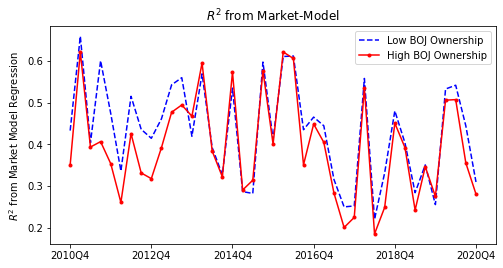

In [16]:
r2_bot_quant_df = nk_r2_df[nk_r2_df['boj_share_shares_quantiles_nk'].isin([1])]
r2_top_quant_df = nk_r2_df[nk_r2_df['boj_share_shares_quantiles_nk'].isin([4])]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.set_xticks([0, 8, 16, 24, 32, 40])

ax.plot(r2_bot_quant_df.groupby('qtr_yr_index_str').mean()['r2'], ls='--', color='b', label='Low BOJ Ownership')
ax.plot(r2_top_quant_df.groupby('qtr_yr_index_str').mean()['r2'], marker='.', color='r', label='High BOJ Ownership')

ax.set_ylabel('$R^2$ from Market Model Regression')
ax.set_title('$R^2$ from Market-Model')

plt.legend()
plt.savefig(PATH+'images/nov_1/r2')
plt.show()

## Other

In [30]:
weight_df = pd.read_pickle(PATH+'checkpoint_data/index_weights.pkl')
nk_weights_2010 = weight_df[(weight_df['indexlistmnem']=='LJAPDOWA') & (weight_df['month']==11) & (weight_df['yr']==2010)]
nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)
nk_weights_2010 = nk_weights_2010[['sedol', '2010_nk_weight_decile', 'weight']]
nk_weights_2010.columns = ['sedol', '2010_nk_weight_decile', 'nk_weight']

<ipython-input-30-0e6a58481e1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)


In [40]:
nk_r2_df_w_2010_weights = pd.merge(nk_r2_df, 
                                   nk_weights_2010, 
                                   on=['sedol'], 
                                   how='left')

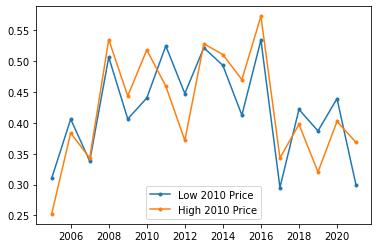

In [119]:
r2_bot_quant_df = nk_r2_df_w_2010_weights[nk_r2_df_w_2010_weights['2010_nk_weight_decile'].isin([3])]
r2_top_quant_df = nk_r2_df_w_2010_weights[nk_r2_df_w_2010_weights['2010_nk_weight_decile'].isin([9])]

plt.plot(r2_bot_quant_df.groupby('fin_date_yr').mean()['r2'], marker='.', label='Low 2010 Price')
plt.plot(r2_top_quant_df.groupby('fin_date_yr').mean()['r2'], marker='.', label='High 2010 Price')
plt.legend()

In [108]:
nk_r2_df_w_2010_weights.drop(columns='qtr_yr_index').to_stata(PATH+'checkpoint_data/r2_reg.dta')

In [ ]:
r2_df['fin_date_yr'] = r2_df['fin_date'].dt.year
r2_df['qtr_yr_index_str'] = r2_df['qtr_yr_index'].apply(lambda x: str(x[0]) + 'Q' + str(x[1]))
plt.plot(r2_df.groupby('fin_date_yr')['r2'].mean())